# Visualization of airport data from OU dataset
- Extracted from rosbag provided by Ohio University 
- Video: 1:42 to 1:51 (ish)

In [1]:
import numpy as np
import pandas as pd
import cv2
import open3d as o3d
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

from pathlib import Path

# SAVE YOUR WORK
%load_ext autoreload
%autoreload 2
%autosave 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Autosaving every 180 seconds


In [2]:
# Import data
# IMU data and GPS data extracted from same 1:42-1:51 timeframe 
imu_path = '/home/daniel-choate/Datasets/OU_SurfNav/Etracted_Data/imu_data.txt'
img_path = '/home/daniel-choate/Datasets/OU_SurfNav/image_frames'
gps_path = '/home/daniel-choate/Datasets/OU_SurfNav/Etracted_Data/gps_data.txt'

# Load the imu data
imu_df = pd.read_csv(imu_path, sep="\t")
gps_df = pd.read_csv(gps_path, sep="\t")

# Load the image data
# img_df = pd.read_csv(img_path, sep="\n")

# Preview
print("IMU data HEAD \n")
print(imu_df.head())
print("\nGPS data HEAD \n")
print(gps_df.head())

IMU data HEAD 

   timestamp_sec  orientation_x  orientation_y  orientation_z  orientation_w  \
0   1.745001e+09      -0.016964       0.011501      -0.507551       0.861378   
1   1.745001e+09      -0.016987       0.011467      -0.507558       0.861374   
2   1.745001e+09      -0.016977       0.011427      -0.507574       0.861365   
3   1.745001e+09      -0.016979       0.011388      -0.507581       0.861361   
4   1.745001e+09      -0.017014       0.011371      -0.507577       0.861363   

   angular_velocity_x  angular_velocity_y  angular_velocity_z  \
0            0.024592           -0.002296            0.001588   
1            0.022175           -0.003239            0.000259   
2            0.018582            0.001247           -0.002275   
3            0.016930            0.004273           -0.003151   
4            0.015795            0.000807           -0.001894   

   linear_acceleration_x  linear_acceleration_y  linear_acceleration_z  
0               0.091799              -

In [3]:
# Load in timestamps from image sequence (218 images)
timestamps = np.load(f"{img_path}/timestamps.npy")

In [4]:
print(timestamps[0], timestamps[-1], len(timestamps))

1745000914.8142636 1745000922.0471263 218


In [5]:
# 1745000914.8142636 1745000914.8470783 218
# 1745000914.8142636 1745000922.0471263 218

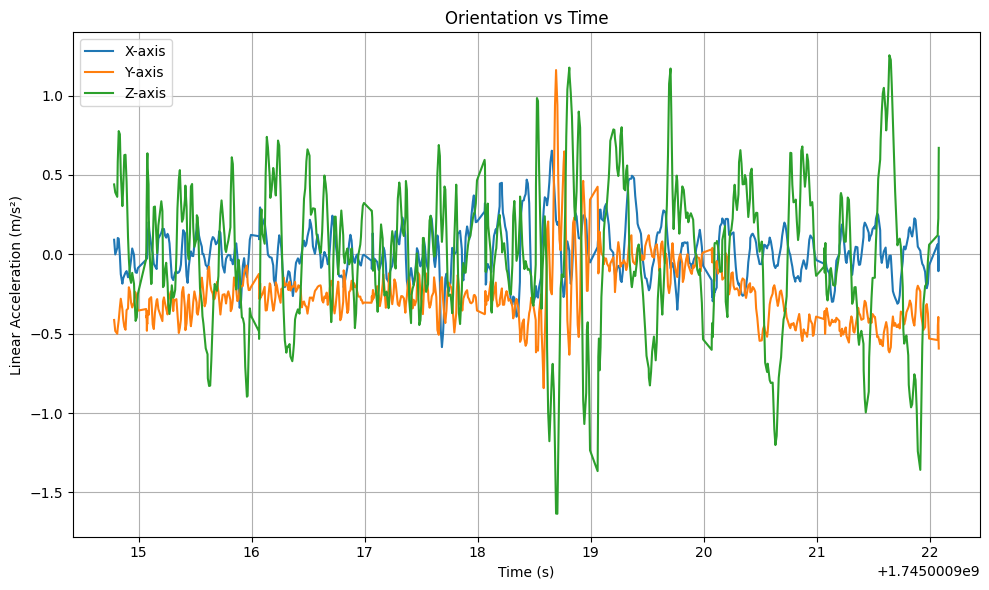

In [6]:
# Plot linear acceleration as a function of time
# NOTE: THIS IS USELESS, BECAUSE ORIENTATION IS IN A QUATERNION; JUST FOR VISUALIZATION PURPOSES

plt.figure(figsize=(10, 6))

plt.plot(imu_df['timestamp_sec'], imu_df['linear_acceleration_x'], label='X-axis')
# plt.plot(imu_df['timestamp_sec'], imu_df['orientation_x'], label='X-axis')
plt.plot(imu_df['timestamp_sec'], imu_df['linear_acceleration_y'], label='Y-axis')
# plt.plot(imu_df['timestamp_sec'], imu_df['orientation_y'], label='Y-axis')
plt.plot(imu_df['timestamp_sec'], imu_df['linear_acceleration_z'], label='Z-axis')
# plt.plot(imu_df['timestamp_sec'], imu_df['orientation_z'], label='Z-axis')

plt.xlabel('Time (s)')
plt.ylabel('Linear Acceleration (m/s²)')
# plt.ylabel('Orientation (rad)')
plt.title('Orientation vs Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

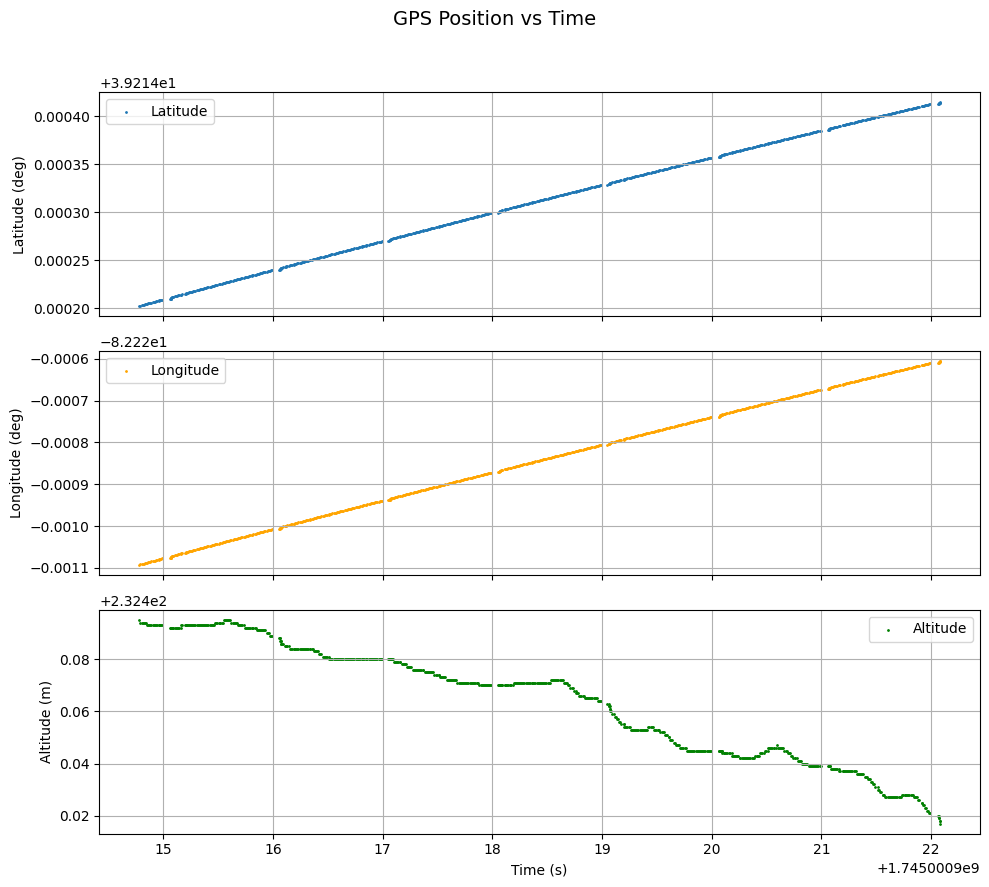

In [7]:
# Plot GPS position as a function of time

fig, axs = plt.subplots(3, 1, figsize=(10,9), sharex=True)

# Latitude
axs[0].scatter(gps_df['timestamp_sec'], gps_df['latitude'], label='Latitude', s=1)
axs[0].set_ylabel('Latitude (deg)')
axs[0].legend()
axs[0].grid(True)

# Longitude
axs[1].scatter(gps_df['timestamp_sec'], gps_df['longitude'], label='Longitude', color='orange', s=1)
axs[1].set_ylabel('Longitude (deg)')
axs[1].legend()
axs[1].grid(True)

# Altitude
axs[2].scatter(gps_df['timestamp_sec'], gps_df['altitude'], label='Altitude', color='green', s=1)
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Altitude (m)')
axs[2].legend()
axs[2].grid(True)


# Set the overall title and layout
fig.suptitle('GPS Position vs Time', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

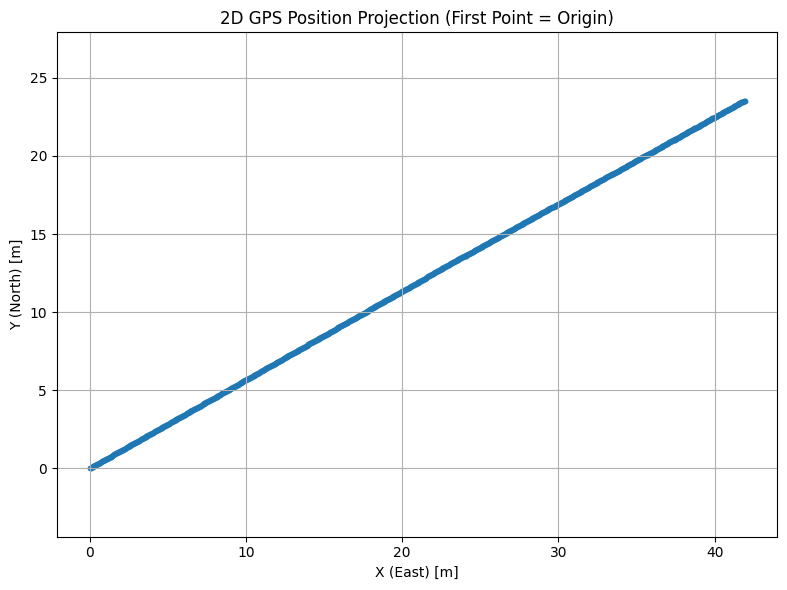

In [8]:
# Earth's radius in meters
rad = 6371000  

# Extract latitude and longitude
lats = gps_df['latitude'].to_numpy()
lons = gps_df['longitude'].to_numpy()

# Convert to radians
lat0 = np.radians(lats[0])
lon0 = np.radians(lons[0])
lat_rad = np.radians(lats)
lon_rad = np.radians(lons)

# Compute deltas
dlat = lat_rad - lat0
dlon = lon_rad - lon0

# Convert to local coordinates (meters)
x = rad * dlon * np.cos(lat0)   # East
y = rad * dlat                  # North

# Plot 2D XY projection
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=10)
plt.xlabel('X (East) [m]')
plt.ylabel('Y (North) [m]')
plt.title('2D GPS Position Projection (First Point = Origin)')
plt.grid(True)
plt.axis('equal')  # To maintain aspect ratio
plt.tight_layout()
plt.show()


In [9]:
# Create rotation matrices from quaternion data
quaternions = np.column_stack([imu_df['orientation_x'], imu_df['orientation_y'], imu_df['orientation_z'], imu_df['orientation_w']])
print(quaternions.shape)
quat_rots = R.from_quat(quaternions).as_matrix()

(728, 4)


In [10]:
print(quat_rots[218])

[[ 0.48427271  0.87399402  0.04017949]
 [-0.87491089  0.48393145  0.01847394]
 [-0.00329801 -0.0440999   0.99902168]]


In [11]:
# Create homogeneous transformation matrix from rotation matrix and translation matrix
def create_homog_tform(rot, trans):
    """ 
    Creating a homogeneous transformation matrix 
    Input: Rotation matrix (3x3), translation matrix (3x1)
    Output: 4x4 homogeneous transformation matrix 
    """
    homog_t = np.eye(4)
    homog_t[:3,:3] = rot
    homog_t[:3,3] = trans
    homog_t[3] = np.array([0,0,0,1])
    # print("homogeneous transformation matrix \n", homog_t)
    return homog_t

In [12]:
for i in range(len(quat_rots)):
    rot = quat_rots[i]
    # print(rot)
    trans = np.array([i,0,0])
    tform = create_homog_tform(rot, trans)

# print(len(quat_rots)," attitude measurements")
print(imu_df['timestamp_sec'][2])
print(gps_df['timestamp_sec'][2])

1745000914.810624
1745000914.8092396


## Looking at raw frames 
- simply adding a translation of 1 unit in the x direction for each frame
- going to incorporate GPS data for an actual translation
- attitude estimations look good, hard to tell without GPS

In [13]:
# Use Open3D for visualization 

# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name = "Ohio Airport attitude data")

# Create axes at origin 
axis_o = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)#.translate([1,0,0])

# Add necessary geometries
vis.add_geometry(axis_o)

# for i in range(len(quat_rots)):
for i in range(1):
    rot = quat_rots[i]
    trans = np.array([i,0,0])
    tform = create_homog_tform(rot, trans) # world --> body
    tform_inv = np.linalg.inv(tform) # body --> world
    # print(tform)
    axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=.75).transform(tform)#.transform(tform_inv)
    vis.add_geometry(axes)

# # ********Size options (jupyter gives issues when running this multiple times, but it looks better)
# render_option = vis.get_render_option()
# render_option.point_size = 2
# # Set up initial viewpoint
# view_control = vis.get_view_control()
# # Direction which the camera is looking
# view_control.set_front([0, 0, -1])  # Set the camera facing direction
# # Point which the camera revolves about 
# view_control.set_lookat([0, 0, 0])   # Set the focus point
# # Defines which way is up in the camera perspective 
# view_control.set_up([0, -1, 0])       # Set the up direction
# view_control.set_zoom(.45)           # Adjust zoom if necessary
# # ****************


# Run and destroy window 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 82
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 82
pci id for fd 82: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


## HOMOGRAPHY Transform

Generating top-down views for a specific image
- NOTE: we are assuming that the camera and the IMU have the same alignment 

In [14]:
# Import first image
im_000_path = "/home/daniel-choate/Datasets/OU_SurfNav/image_frames/000000.png"
im_000 = cv2.imread(im_000_path)
im_000 = cv2.cvtColor(im_000, cv2.COLOR_BGR2RGB)

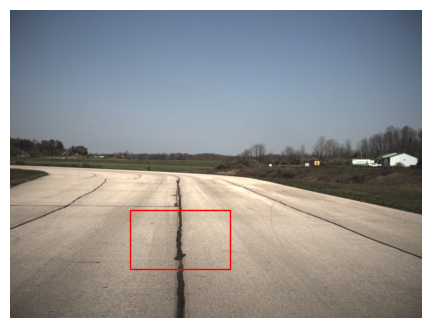

In [15]:
# Grab pts as 3D points 
x = 600
y = 1000
width, height = 500, 300

x_coords = np.arange(x, x+width)
y_coords = np.arange(y, y+height)
Px, Py = np.meshgrid(x_coords, y_coords, indexing='xy')
# print(Px.shape,Py.shape)

ones = np.ones_like(Px)
pts_pix = np.stack((Px,Py,ones), axis=-1)
pts_pix_rgb = im_000[y:y+height, x:x+width]
pts_pix = pts_pix.reshape(-1,3)
pts_pix_rgb = pts_pix_rgb.reshape(-1,3)
# print(pts_pix_rgb)
# print(pts_pix)

fig, ax = plt.subplots(figsize=(15,4))
# Draw rectangle 
rect = plt.Rectangle((x,y), width, height, linewidth=1, edgecolor='r', facecolor='none')

# Plot 
ax.imshow(im_000)
ax.add_patch(rect)
ax.axis("off")

# Show plot 
plt.show()

In [16]:
print(pts_pix_rgb)

[[194 171 149]
 [189 179 147]
 [183 171 147]
 ...
 [175 154 136]
 [187 164 140]
 [180 167 144]]


In [21]:
# Plot 2D pixel images 
# Use Open3D for visualization 

# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name = "Ohio Airport attitude data")

# Create axes at origin 
axis_o = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1000)#.translate([1,0,0])

pix_cloud = o3d.geometry.PointCloud()
pix_cloud.points = o3d.utility.Vector3dVector(pts_pix)
pix_cloud.colors = o3d.utility.Vector3dVector(pts_pix_rgb/255)

# Add necessary geometries
vis.add_geometry(axis_o)
vis.add_geometry(pix_cloud)

# for i in range(len(quat_rots)):
for i in range(1):
    rot = quat_rots[i]
    trans = np.array([i,0,0])
    tform = create_homog_tform(rot, trans) # world --> body
    tform_inv = np.linalg.inv(tform) # body --> world
    # print(tform)
    axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=500).transform(tform)#.transform(tform_inv)
    vis.add_geometry(axes)


# Run and destroy window 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 82
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 82
pci id for fd 82: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


In [18]:
# Transform points based inertial orientation
x = np.ones((pts_pix.shape[0],1))
ppn = np.hstack((pts_pix, x))

# print(pts_pix.shape)
# print(x.shape)

pts_pix_new = ppn @ tform

# x = np.ones((pts_pix.shape[0],1))
# print(x)
print(pts_pix_new)

[[-5.84067528e+02  1.00856530e+03  4.07694638e+01  1.00000000e+00]
 [-5.83583009e+02  1.00943930e+03  4.08064974e+01  1.00000000e+00]
 [-5.83098489e+02  1.01031330e+03  4.08435310e+01  1.00000000e+00]
 ...
 [-6.04819556e+02  1.58771976e+03  6.44226568e+01  1.00000000e+00]
 [-6.04335036e+02  1.58859375e+03  6.44596904e+01  1.00000000e+00]
 [-6.03850517e+02  1.58946775e+03  6.44967240e+01  1.00000000e+00]]


In [20]:
# Plot 2D pixel images 
# Use Open3D for visualization 

# Create visualization 
vis = o3d.visualization.Visualizer()
vis.create_window(window_name = "Ohio Airport attitude data")

# Create axes at origin 
axis_o = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1000)#.translate([1,0,0])

pix_cloud = o3d.geometry.PointCloud()
pix_cloud.points = o3d.utility.Vector3dVector(pts_pix_new[:,:3])
pix_cloud.colors = o3d.utility.Vector3dVector(pts_pix_rgb/255)

# Add necessary geometries
vis.add_geometry(axis_o)
vis.add_geometry(pix_cloud)

# for i in range(len(quat_rots)):
for i in range(1):
    rot = quat_rots[i]
    trans = np.array([i,0,0])
    tform = create_homog_tform(rot, trans) # world --> body
    tform_inv = np.linalg.inv(tform) # body --> world
    # print(tform)
    axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=500).transform(tform)#.transform(tform_inv)
    vis.add_geometry(axes)


# Run and destroy window 
vis.run()
vis.destroy_window()

libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 82
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
using driver i915 for 82
pci id for fd 82: 8086:a7a0, driver iris
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
libGL: Can't open configuration file /etc/drirc: No such file or directory.
libGL: Can't open configuration file /home/daniel-choate/.drirc: No such file or directory.
Using DRI3 for screen 0


In [ ]:
# Creating rotation matrix gRc (from camera to ground)
# print(imu_df['timestamp_sec'])
# print(imu_df['angular_velocity_x'])

print(quat_rots[10])

In [ ]:
# Guess correspondences 

pts_im = np.array([[600,1000],
                  [600,1200],
                  [1100,1000],
                  [1100,1200]])


fig, ax = plt.subplots(figsize=(15,8))

ax.imshow(im_000)
ax.axis("off")
# print(pts_im[:,0])
plt.scatter(pts_im[:,0],pts_im[:,1])

# Show plot 
plt.show()

# PROJECTION STEPS 

1) [ ] Grab world to camera rotation
2) [ ] Transform ground normal to camera frame
3) [ ] Rotate n_c onto ez (use cross product and rodrigues formula)
4) [ ] Estimate intrinsics
5) [ ] Homography 

In [ ]:
# STEP 1
rot = quat_rots[0]
# trans = np.array([i,0,0])
# tform = create_homog_tform(rot, trans)

# STEP 2
n_w = np.array([0,0,1])
n_c = rot @ n_w

# STEP 3
ez = np.array([0.0,0.0,1.0])
# Cross product 
v = np.cross(n_c, ez)
print("V = ", v)
s = np.linalg.norm(v)
print("S = ", s)
c = float(np.dot(n_c, ez))

vx = np.array([[    0, -v[2],  v[1]],
               [ v[2],     0, -v[0]],
               [-v[1],  v[0],     0]])

print("V matrix = \n", vx)
# Rodrigues formula
R_align = np.eye(3) + vx + vx @ vx * ((1 - c) / (s**2))
print("Alignment matrix = \n", R_align)

# STEP 4
W = im_000.shape[1]
H = im_000.shape[0]
f = float(max(W, H))
print("f = ", f)
K = np.array([[f, 0, W/2],
              [0, f, H/2],
              [0, 0,   1 ]], dtype=float)
K_inv = np.linalg.inv(K)

# STEP 5 
Homography = K @ R_align @ K_inv

print("HOMOGRAPHY = \n", Homography)

In [ ]:
# WARP IMAGE 
H = im_000.shape[0]
W = im_000.shape[1]
birds_EV = cv2.warpPerspective(im_000, Homography, (W,H))

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(birds_EV)
ax.axis("off")

# Show plot 
plt.show()